## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)



In [4]:
len(fmnist_dataset_test), len(fmnist_dataset_train)

(10000, 60000)

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
val_size = 10000

fmnist_dataset_train, fmnist_dataset_val = train_test_split(fmnist_dataset_train, train_size=50000)

train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

val_loader = torch.utils.data.DataLoader(fmnist_dataset_val, 
                                           batch_size=256,
                                           shuffle=True,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [7]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [8]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

Для начала посмотрим на двуслойноую модель.

In [24]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here           
            nn.Linear(input_shape, 50),
            nn.ReLU(), 
            nn.Linear(50, num_classes), 
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [25]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 50]          39,250
              ReLU-3                   [-1, 50]               0
            Linear-4                   [-1, 10]             510
        LogSoftmax-5                   [-1, 10]               0
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.15
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


In [9]:
def val_train_loop(net, train_loader, val_loader, name, optimizer, n_epoch=20, criterion = nn.NLLLoss()):
    loss_history = []
    acc_history = []
    val_loss_history = []
    val_acc_history = []
    
    for i in tqdm(range(n_epoch)):
        acc_batches=[]
        loss_batches=[]
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            # Forward
            predictions = net.forward(x_batch)
            loss = criterion(predictions, y_batch)
            
            # Accuracy
            test_acc = accuracy_score(predictions.argmax(axis=1), y_batch)
            acc_batches.append(test_acc)
            
            # Backward
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_batches.append(loss.detach().numpy())

        loss_history.append(np.mean(loss_batches))
        acc_history.append(np.mean(acc_batches))
        
        
        # Validating
        net.eval()
        with torch.no_grad():
            val_acc_batches=[]
            val_loss_batches=[]
            for X_val, Y_val in val_loader:    
                X_val = X_val.to(device)
                Y_val = Y_val.to(device)
                val_predictions = net.forward(X_val)
                val_loss = criterion(val_predictions, Y_val)
                val_loss_batches.append(val_loss)
                val_acc = accuracy_score(val_predictions.argmax(axis=1), Y_val)
                val_acc_batches.append(val_acc)
        net.train()
        
        val_loss_history.append(np.mean(val_loss_batches))
        val_acc_history.append(np.mean(val_acc_batches))
        
        clear_output(wait=True)
        
        plt.figure(figsize=(8, 5))

        plt.title(f"Training/validating loss {name}")
        plt.xlabel("#epoch")
        plt.ylabel("Loss")
        plt.plot(loss_history, 'b', label='train')
        plt.plot(val_loss_history, 'r', label='validation')
        plt.legend()
        
        clear_output(wait=True)
        plt.figure(figsize=(8, 5))
        plt.title(f"Training/validating accuracy {name}")
        plt.xlabel("#epoch")
        plt.ylabel("Accuracy")
        plt.plot(acc_history, 'b', label='train')
        plt.plot(val_acc_history, 'r', label='validation')
        plt.legend()
        
        plt.show()
        
        print('Current validation accuracy: %f' % np.mean(val_acc_batches))

In [10]:
def test_accuracy(model):
    model.eval()
    test_acc_batches = []
    for X_test, Y_test in test_loader:    
        X_test = X_test.to(device)
        Y_test = Y_test.to(device)
        test_predictions = model.forward(X_test)
        test_acc = accuracy_score(test_predictions.argmax(axis=1), Y_test)
        test_acc_batches.append(test_acc)

    print(f'Test accuracy {np.mean(test_acc_batches)}')

Your experiments come here:

In [28]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-2, betas=(0.9, 0.99), eps=1e-8)
loss_func = nn.NLLLoss()
n_epoch = 15
# Your experiments, training and validation loops here

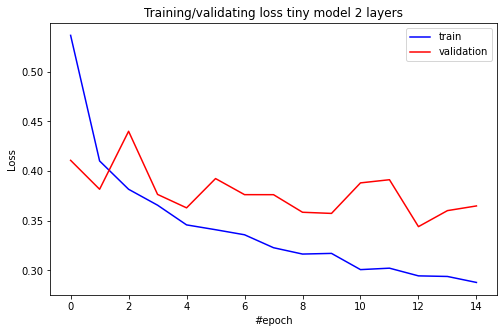

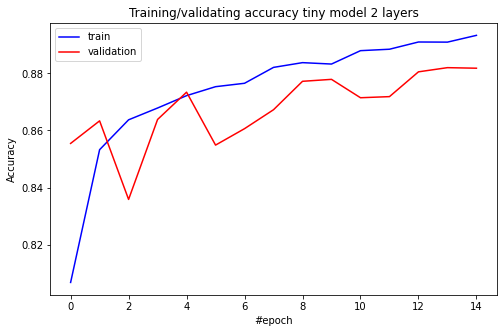

100%|██████████| 15/15 [00:42<00:00,  2.83s/it]

Current validation accuracy: 0.881836
CPU times: user 1min 5s, sys: 5.57 s, total: 1min 10s
Wall time: 42.4 s


In [29]:
%%time
val_train_loop(model, train_loader=train_loader, val_loader=val_loader, name='tiny model 2 layers', optimizer=opt, n_epoch=n_epoch)

In [30]:
test_accuracy(model)

Test accuracy 0.8646484375


Видно, что уже после 8 итераций наступает переобучение, loss на валидации начинает идти вверх. К тому же еще невероятно медленно отрабатывает каждая итерация. Заменим на сетку с 3 слоями(без попыток избежания переобучения).

In [25]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1, 
                 batch_norm=False, dropout=False, num_layers=3, width=100):
        super(self.__class__, self).__init__()
        
        modules = []
        
        modules.append(nn.Flatten())
        modules.append(nn.Linear(input_shape, width))
        if batch_norm:
            modules.append(nn.BatchNorm1d(width))
        modules.append(nn.ReLU())
        if dropout:
            modules.append(nn.Dropout(p=0.6))
        modules.append(nn.Linear(width, 100))
        modules.append(nn.ReLU())
        
        modules.append(nn.Linear(100, num_classes))
        modules.append(nn.LogSoftmax(dim=1))
        
        self.model = nn.Sequential(*modules)
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [12]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
              ReLU-3                  [-1, 100]               0
            Linear-4                  [-1, 100]          10,100
              ReLU-5                  [-1, 100]               0
            Linear-6                   [-1, 10]           1,010
        LogSoftmax-7                   [-1, 10]               0
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.34
Estimated Total Size (MB): 0.35
----------------------------------------------------------------


In [14]:
simple_model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(simple_model.parameters(), lr=1e-2, betas=(0.9, 0.99), eps=1e-8)
loss_func = nn.NLLLoss()
n_epoch = 15

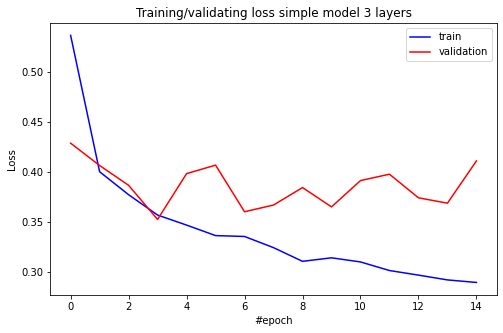

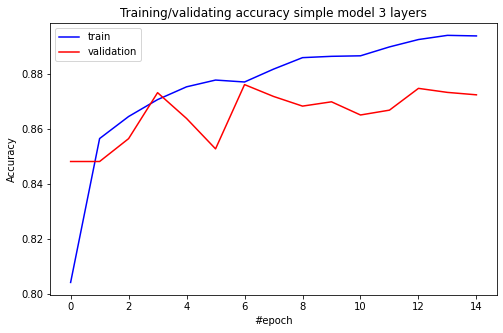

100%|██████████| 15/15 [00:54<00:00,  3.66s/it]

Current validation accuracy: 0.872266
CPU times: user 1min 29s, sys: 6.16 s, total: 1min 35s
Wall time: 54.9 s


In [15]:
%%time
val_train_loop(simple_model, train_loader=train_loader, val_loader=val_loader, name='simple model 3 layers', optimizer=opt, n_epoch=n_epoch)

In [16]:
test_accuracy(simple_model)

Test accuracy 0.864453125


Все еще переобучение. Добваим batch_norm и dropout.

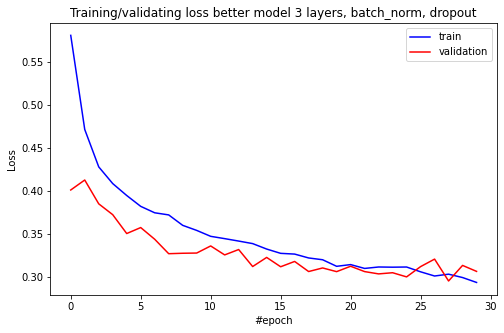

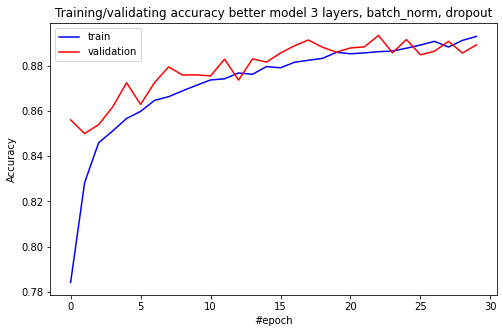

100%|██████████| 30/30 [03:06<00:00,  6.22s/it]

Current validation accuracy: 0.889258
CPU times: user 5min 32s, sys: 13.4 s, total: 5min 45s
Wall time: 3min 6s


In [27]:
%%time
better_model = TinyNeuralNetwork(batch_norm=True, dropout=True, width=500).to(device)
opt = torch.optim.Adam(better_model.parameters(), lr=1e-2, betas=(0.9, 0.99), eps=1e-8)
n_epoch = 30

val_train_loop(better_model, train_loader=train_loader, val_loader=val_loader, name='better model 3 layers, batch_norm, dropout', optimizer=opt, n_epoch=n_epoch)

In [29]:
test_accuracy(better_model)

Test accuracy 0.88828125


Наконец-то получилось нормально обучить модель, droput и batch norm слои позволили не переобучиться модели даже на 30 эпохах.

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [39]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1, width=500):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, width),
            nn.ReLU(),
            nn.Linear(width, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes),
             nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [32]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
              ReLU-3                  [-1, 500]               0
            Linear-4                  [-1, 100]          50,100
              ReLU-5                  [-1, 100]               0
            Linear-6                   [-1, 10]           1,010
        LogSoftmax-7                   [-1, 10]               0
Total params: 443,610
Trainable params: 443,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.69
Estimated Total Size (MB): 1.71
----------------------------------------------------------------


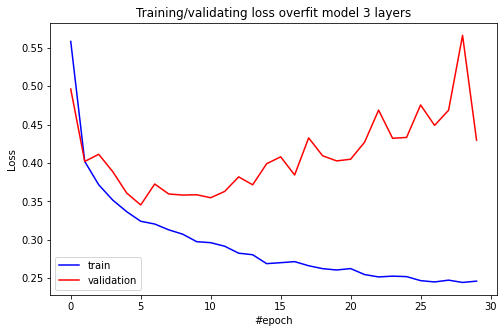

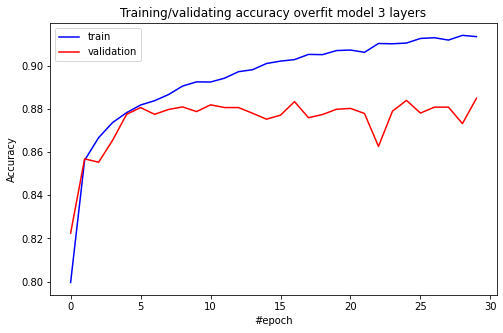

100%|██████████| 30/30 [05:04<00:00, 10.16s/it]

Current validation accuracy: 0.884863
CPU times: user 9min 23s, sys: 13.6 s, total: 9min 36s
Wall time: 5min 4s


In [34]:
%%time
overfit_model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(overfit_model.parameters(), lr=1e-2, betas=(0.9, 0.99), eps=1e-8)
n_epoch = 30

val_train_loop(overfit_model, train_loader=train_loader, val_loader=val_loader, name='overfit model 3 layers', optimizer=opt, n_epoch=n_epoch)
# Your experiments, come here

In [35]:
test_accuracy(overfit_model)

Test accuracy 0.87607421875


Переобучение на лицо, validating loss летит выше, пока training loss стабильно падает(то есть алгоритм обучения работает корректно). При этом accuracy на test выборке повышается до 90%, а на валидации остается постоянным. Можно даже наблюдать, насколько нелогично друг относительно друга они расположены, валидационная выборка то в 5 раз меньше объемом. 

Можно подумать о том, чтобы сделать число эпох поменьше или широту слоя побольше, однако тогда просто недостигнем желаемой точности, проверим это.

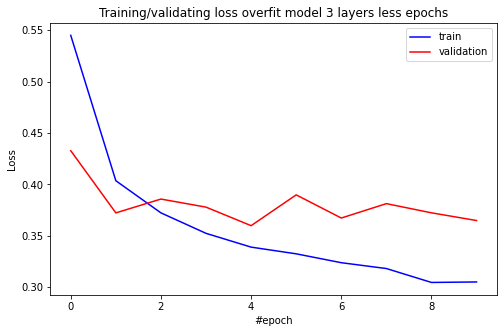

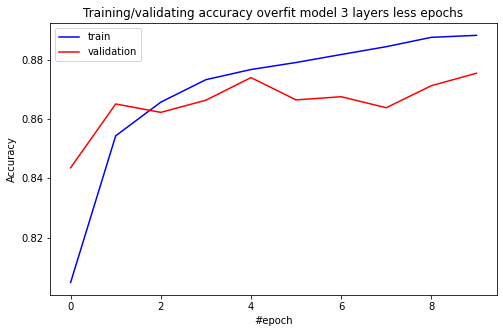

100%|██████████| 10/10 [01:08<00:00,  6.85s/it]

Current validation accuracy: 0.875391
CPU times: user 2min 2s, sys: 4.59 s, total: 2min 7s
Wall time: 1min 8s


In [42]:
%%time
n_epoch = 10
overfit_model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(overfit_model.parameters(), lr=1e-2, betas=(0.9, 0.99), eps=1e-8)
val_train_loop(overfit_model, train_loader=train_loader, val_loader=val_loader, 
               name='overfit model 3 layers less epochs', optimizer=opt, n_epoch=n_epoch)

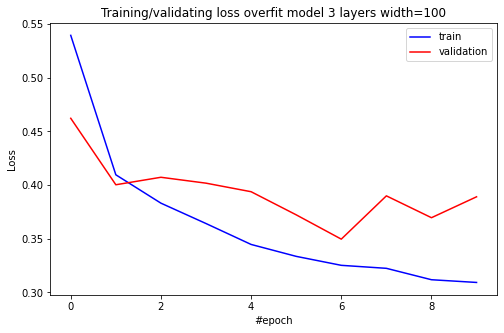

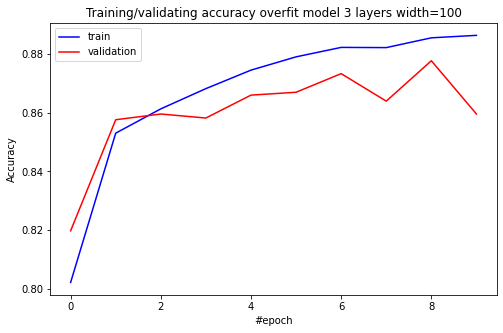

100%|██████████| 10/10 [00:33<00:00,  3.40s/it]

Current validation accuracy: 0.859570
CPU times: user 55 s, sys: 4.07 s, total: 59 s
Wall time: 34 s


In [43]:
%%time
n_epoch = 10
overfit_model = OverfittingNeuralNetwork(width=100).to(device)
opt = torch.optim.Adam(overfit_model.parameters(), lr=1e-2, betas=(0.9, 0.99), eps=1e-8)
val_train_loop(overfit_model, train_loader=train_loader, val_loader=val_loader, 
               name='overfit model 3 layers width=100', optimizer=opt, n_epoch=n_epoch)

In [48]:
test_accuracy(overfit_model)

Test accuracy 0.8541015625


Проблему это не решило, уже за 5 эпох модель переобучается, нужно добавлять нормализацию и dropout слои.

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [13]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1, 
                 batch_norm=False, dropout=False, num_layers=3, width=100):
        super(self.__class__, self).__init__()
        
        modules = []
        
        modules.append(nn.Flatten())
        modules.append(nn.Linear(input_shape, width))
        if batch_norm:
            modules.append(nn.BatchNorm1d(width))
        modules.append(nn.ReLU())
        if dropout:
            modules.append(nn.Dropout(p=dropout))
        modules.append(nn.Linear(width, 100))
        modules.append(nn.ReLU())
        
        modules.append(nn.Linear(100, num_classes))
        modules.append(nn.LogSoftmax(dim=1))
        
        self.model = nn.Sequential(*modules)
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [45]:
torchsummary.summary(FixedNeuralNetwork(batch_norm=True, dropout=True, width=500).to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
       BatchNorm1d-3                  [-1, 500]           1,000
              ReLU-4                  [-1, 500]               0
           Dropout-5                  [-1, 500]               0
            Linear-6                  [-1, 100]          50,100
              ReLU-7                  [-1, 100]               0
            Linear-8                   [-1, 10]           1,010
        LogSoftmax-9                   [-1, 10]               0
Total params: 444,610
Trainable params: 444,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.70
Estimated Total Size (MB): 1.72
-------------------------------------------

Начнем с добавления dropout слоя.

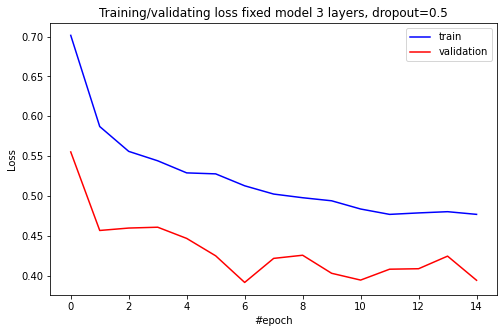

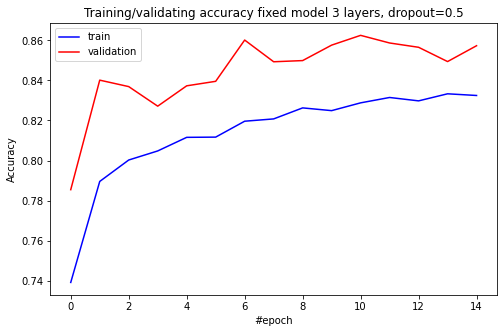

100%|██████████| 15/15 [01:51<00:00,  7.44s/it]

Current validation accuracy: 0.857324
CPU times: user 3min 20s, sys: 7.01 s, total: 3min 27s
Wall time: 1min 51s


In [49]:
%%time
model_dp = FixedNeuralNetwork(batch_norm=False, dropout=0.5, width=500).to(device)
opt = torch.optim.Adam(model_dp.parameters(), lr=1e-2, betas=(0.9, 0.99), eps=1e-8)
n_epoch = 15

# Your experiments, come here
val_train_loop(model_dp, train_loader=train_loader, val_loader=val_loader, name='fixed model 3 layers, dropout=0.5', optimizer=opt, n_epoch=n_epoch)

In [52]:
test_accuracy(model_dp)

Test accuracy 0.85390625


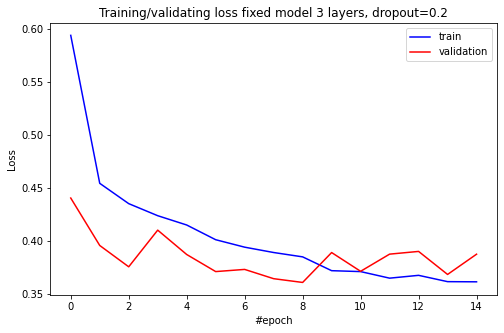

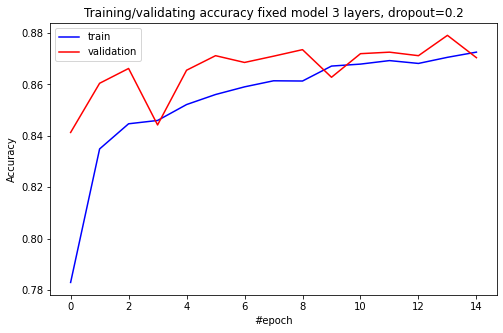

100%|██████████| 15/15 [01:54<00:00,  7.66s/it]

Current validation accuracy: 0.870410
CPU times: user 3min 25s, sys: 7.13 s, total: 3min 33s
Wall time: 1min 54s


In [59]:
%%time
model_dp = FixedNeuralNetwork(batch_norm=False, dropout=0.2, width=500).to(device)
opt = torch.optim.Adam(model_dp.parameters(), lr=1e-2, betas=(0.9, 0.99), eps=1e-8)
n_epoch = 15

# Your experiments, come here
val_train_loop(model_dp, train_loader=train_loader, val_loader=val_loader, name='fixed model 3 layers, dropout=0.2', optimizer=opt, n_epoch=n_epoch)

In [60]:
test_accuracy(model_dp)

Test accuracy 0.87119140625


Классно, один добавленный слой сразу же избавляет нас от переобучения, красная линия там, где она должна быть, 15 эпох все еще не хватает для получения отличной точности, дальше можно запустить на подольше.

Стоит отметить, что 0.5-0.6 для dropout'а оптимальная константа, при маленькой вероятности выключения нейрона все равно будем близки к переобучению, при большой, будем обучаться медленно, так как информацию будем терять.

Теперь отдельно добавим batch norm.

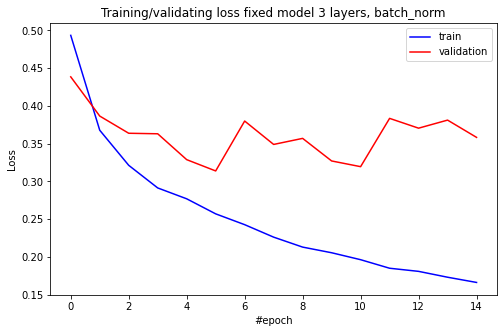

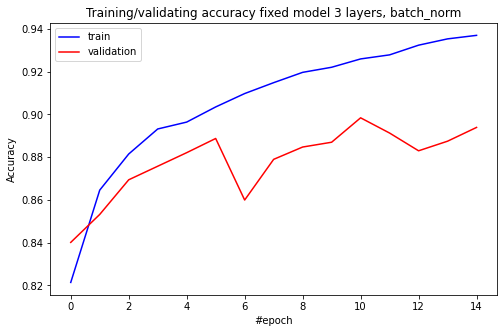

100%|██████████| 15/15 [01:40<00:00,  6.67s/it]

Current validation accuracy: 0.893945
CPU times: user 2min 54s, sys: 7.03 s, total: 3min 1s
Wall time: 1min 40s


In [55]:
%%time
model_bn = FixedNeuralNetwork(batch_norm=True, dropout=False, width=500).to(device)
opt = torch.optim.Adam(model_bn.parameters(), lr=1e-2, betas=(0.9, 0.99), eps=1e-8)
n_epoch = 15

# Your experiments, come here
val_train_loop(model_bn, train_loader=train_loader, val_loader=val_loader, name='fixed model 3 layers, batch_norm', optimizer=opt, n_epoch=n_epoch)

In [56]:
test_accuracy(model_bn)

Test accuracy 0.8884765625


Batch norm не избавил от страданий, dropout оказал более сильное влияние.

Объеденим методы, должно получиться круто, сильно увеличим количество эпох, чтобы проверить, что переобучения реально не случиться.

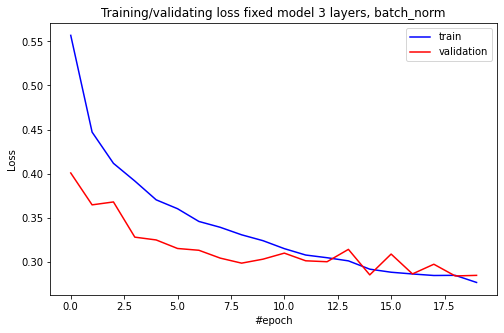

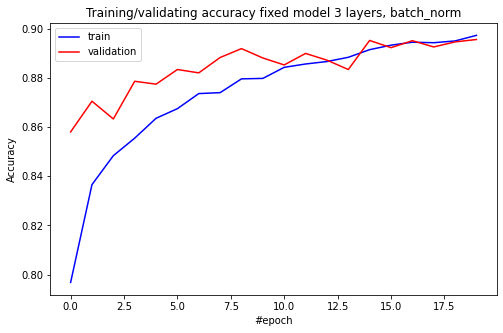

100%|██████████| 20/20 [02:48<00:00,  8.44s/it]

Current validation accuracy: 0.895605
CPU times: user 4min 55s, sys: 13.6 s, total: 5min 8s
Wall time: 2min 48s


In [17]:
%%time
best_model = FixedNeuralNetwork(batch_norm=True, dropout=0.6, width=500).to(device)
opt = torch.optim.Adam(best_model.parameters(), lr=0.5e-2, betas=(0.9, 0.99), eps=1e-8)
n_epoch = 20

# Your experiments, come here
val_train_loop(best_model, train_loader=train_loader, val_loader=val_loader, name='fixed model 3 layers, batch_norm', optimizer=opt, n_epoch=n_epoch)

In [18]:
test_accuracy(best_model)

Test accuracy 0.88837890625


### Conclusions:
_Write down small report with your conclusions and your ideas._

Промежуточные выводы можно прочитать в ноутбуке.

Изначально был выбран путь четного тестирования модели -- train часть была разделена на обучающую и валидационную. Тестирование производилось на данных, которые нейронная сеть никогда не видела. На каждой итерации(эпохи) строилиь средние значения loss и accuracy на валидационной и обучательной выборке.

Либо данные, либо архитектура сети способствовали легкому переобучению. На маленьких колмчествах эпох не достигалось достаточно хорошей точности, а при долгом обучении случалось переобучение, accuracy на валидации не превышало 88%.

При помощи batch norm и dropout была достигнута точность в 89% на тестовой выборке.

При чем по отдельности вклад dropout'а был намного сильнее.

Стоит отметить, что 0.5-0.6 для dropout'а оптимальная константа, при маленькой вероятности выключения нейрона все равно были близки к переобучению, при большой, обучение до достаточной точности была слишком долгим так как информация при обучении терялась.

В комбинации эти методы показали себя отлично, в итоге сеть обучалась 40 эпох и дала результат в 89%.